In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os
import re


-------Scaling array extract-------

In [4]:
# Defining Functions 
def extract_angle(filename):
    # Look for the last number at the end of the filename, even if there's no extension
    match = re.search(r"(\d+(?:\.\d+)?)\s*(?=\s*$|\.\w+$)", filename)
    return float(match.group(1)) if match else None

def extract_data_from_single_file(file_path):
    try:
        # Read the first line to detect separator
        with open(file_path, 'r', encoding='ISO-8859-1') as f:
            first_line = f.readline()

        # Determine the separator
        sep_used = ',' if ',' in first_line else r'\s+'

        # Read the file with the detected separator
        df = pd.read_csv(
            file_path,
            sep=sep_used,
            header=None,
            names=['wavenumber', 'R'],
            encoding='ISO-8859-1',
            engine='python'  # required for regex sep
        )
        return df

    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    
# Function to iterate through the folder and extract data for different angles
def read_dpt_files_in_folder(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        angle = extract_angle(file)
        if angle is not None:
            # Construct the full file path
            file_path = os.path.join(folder_path, file)
            # Extract data from the file
            df = extract_data_from_single_file(file_path)
            if df is not None:
                data[angle] = df
        
            
            
    return data

In [5]:
scale_path_1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250718/Scaling array data'
scale_dic = read_dpt_files_in_folder(scale_path_1)


In [6]:
def smooth_by_wavenumber(df, window_width=40):
    wn = df.iloc[:, 0].values  # wavenumber array
    ratio = df.iloc[:, 1].values  # ratio array

    smoothed_ratio = np.empty_like(ratio)

    for i, center_wn in enumerate(wn):
        # Create mask for window centered on current wavenumber
        mask = (wn >= center_wn - window_width) & (wn <= center_wn + window_width)
        smoothed_ratio[i] = np.mean(ratio[mask])

    return smoothed_ratio

In [7]:
ratio_array_0 = smooth_by_wavenumber(scale_dic[0])

ratio_array_1 = smooth_by_wavenumber(scale_dic[1])
ratio_array_2 = smooth_by_wavenumber(scale_dic[2])
ratio_array_3 = smooth_by_wavenumber(scale_dic[3])
ratio_array_4 = smooth_by_wavenumber(scale_dic[4])
ratio_array_5 = smooth_by_wavenumber(scale_dic[5])
wavenumbers_toplot = scale_dic[1].iloc[:, 0].values

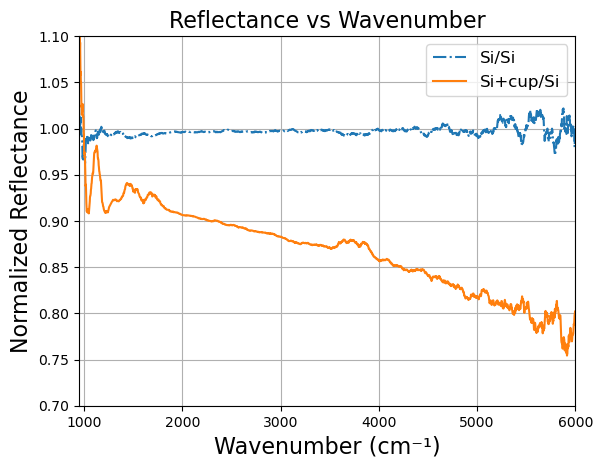

In [8]:
plt.plot(scale_dic[3].iloc[:, 0].values, ratio_array_0, label=f"Si/Si", linestyle='-.')
plt.plot(scale_dic[3].iloc[:, 0].values, ratio_array_2, label=f"Si+cup/Si")
plt.title(f'Reflectance vs Wavenumber', fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize = 16)
plt.ylabel("Normalized Reflectance", fontsize = 16)
plt.xlim(950, 6000)
plt.ylim(0.70, 1.1)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


-------------------------------------------------

————————Experiment extract data————————

In [9]:
folder_path_1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250704/Si_Au/data'
folder_path_2 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250704/Si_Au_H2O/data'

In [10]:
data_y1 = read_dpt_files_in_folder(folder_path_1)
data_y2 = read_dpt_files_in_folder(folder_path_2)

In [11]:
# --- !! WAVENUMERS TO BE USED ---
exp_wavenumbers = data_y1[5]['wavenumber'].values


In [12]:
def compute_normed_ratio(data_y1, data_y2, window):
    data_ratio = {}
    data_ratio_smoothed = {}  # New dictionary for smoothed values

    for angle in data_y1:
        if angle in data_y2:
            df1 = data_y1[angle]
            df2 = data_y2[angle]

            # Ensure wavenumbers match
            if np.allclose(df1['wavenumber'], df2['wavenumber']):
                wn = df1['wavenumber'].values
                R1 = df1['R'].values
                R2 = df2['R'].values

                ratio = np.where(R1 != 0, R2 / R1, np.nan)

                # --- Compute sliding average ---
                ratio_smooth = []
                for i, center_wn in enumerate(wn):
                    # Get mask for points within ±window cm⁻¹
                    mask = (wn >= center_wn - window) & (wn <= center_wn + window)
                    valid = ~np.isnan(ratio[mask])
                    if np.any(valid):
                        avg = np.mean(ratio[mask][valid])
                    else:
                        avg = np.nan
                    ratio_smooth.append(avg)

                # Store raw and smoothed ratio
                df_ratio = pd.DataFrame({
                    'wavenumber': wn,
                    'Normed R': ratio
                })
                df_ratio_smooth = pd.DataFrame({
                    'wavenumber': wn,
                    'Smoothed Normed R': ratio_smooth
                })

                data_ratio[angle-3] = df_ratio
                data_ratio_smoothed[angle-3] = df_ratio_smooth
            else:
                print(f"Wavenumbers do not match at angle {angle}. Skipping.")
        else:
            print(f"Angle {angle} missing in data_y2. Skipping.")

    return data_ratio, data_ratio_smoothed


In [13]:
window = 50 #wavenumber smoothing window in cm^-1
data_normed, data_normed_smoothed = compute_normed_ratio(data_y1, data_y2,window)

In [14]:
# --- !! BASIS: Experiment 50 deg R norm values (smoothed) ---
exp_Rnorm_47 = data_normed_smoothed[47]['Smoothed Normed R'].values

In [15]:
# plt.plot(exp_wavenumbers, exp_Rnorm_47, label=f"{angle}°")
# plt.xlim(950, 6000)
# plt.ylim(0, 1.2)
# plt.grid(True)
# plt.show()


--------------------------------------------

————————Theory calculations extract data————————

In [16]:
#path to Excel file
file_path = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250328/H2O refractive index.xlsx"
file_path2 = "/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250604/Au refractive index.xlsx"

# Read the Excel file
df_full = pd.read_excel(file_path, engine='openpyxl', nrows=168)
df_full2 = pd.read_excel(file_path2, engine='openpyxl', nrows=447)

# Extract the 2nd, 3rd, and 4th columns (indexing starts from 0)
water_nk = df_full.iloc[:, [1, 2, 3]]
Au_nk = df_full2.iloc[:, [1, 2, 3]]

# Rename the columns for clarity
water_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]
Au_nk.columns = ["Wavenumber (cm⁻¹)", "n (real)", "k (imag)"]


In [17]:
# --- Interpolation and forming dataframe---
# --- Interpolate WATER ---
wn_water = water_nk["Wavenumber (cm⁻¹)"].values
n_water = water_nk["n (real)"].values
k_water = water_nk["k (imag)"].values

n_water_interp = interp1d(wn_water, n_water, kind='linear', fill_value="extrapolate")(exp_wavenumbers)
k_water_interp = interp1d(wn_water, k_water, kind='linear', fill_value="extrapolate")(exp_wavenumbers)

# Replace water_nk with interpolated version
water_nk = pd.DataFrame({
    "Wavenumber (cm⁻¹)": exp_wavenumbers,
    "n (real)": n_water_interp,
    "k (imag)": k_water_interp
})

# --- Interpolate GOLD (Au) ---
wn_Au = Au_nk["Wavenumber (cm⁻¹)"].values
n_Au = Au_nk["n (real)"].values
k_Au = Au_nk["k (imag)"].values

n_Au_interp = interp1d(wn_Au, n_Au, kind='linear', fill_value="extrapolate")(exp_wavenumbers)
k_Au_interp = interp1d(wn_Au, k_Au, kind='linear', fill_value="extrapolate")(exp_wavenumbers)

# Replace Au_nk with interpolated version
Au_nk = pd.DataFrame({
    "Wavenumber (cm⁻¹)": exp_wavenumbers,
    "n (real)": n_Au_interp,
    "k (imag)": k_Au_interp
})

# --- Merge using same logic as before ---
interp_n = Au_nk["n (real)"].values
interp_k = Au_nk["k (imag)"].values
target_wavenumbers = water_nk["Wavenumber (cm⁻¹)"].values  # same as exp_wavenumbers

Au_interp = pd.DataFrame({
    "Wavenumber (cm⁻¹)": target_wavenumbers,
    "n (real)": interp_n,
    "k (imag)": interp_k
})

# Final merged DataFrame (same as before)
merged_nk = pd.merge(
    water_nk,
    Au_interp,
    on="Wavenumber (cm⁻¹)",
    suffixes=("_water", "_Au")
)

In [18]:
# merged_nk

In [19]:
# # ---R vs angle ---
# selected_wavenumbers = [1500, 2000,3200,4000, 5000]  # or any wavenumbers you want

# # --- Sorted angle list from the dictionary ---
# angles = sorted(data_normed_smoothed.keys())

# # --- Get available wavenumbers from any sample DataFrame ---
# sample_df = next(iter(data_normed_smoothed.values()))
# available_wavenumbers = sample_df["wavenumber"].values

# # --- Match to nearest available wavenumber ---
# rounded_wavenumbers = [
#     available_wavenumbers[np.argmin(np.abs(available_wavenumbers - wn))]
#     for wn in selected_wavenumbers
# ]

# # --- Plot reflectance vs angle for each wavenumber ---
# plt.figure(figsize=(8, 6))

# for wn in rounded_wavenumbers:
#     reflectances = []
#     for angle in angles:
#         df = data_normed_smoothed[angle]
#         matched_row = df[np.isclose(df["wavenumber"], wn)]
#         if not matched_row.empty:
#             reflectances.append(matched_row["Smoothed Normed R"].values[0])
#         else:
#             reflectances.append(np.nan)  # or 0, depending on preference

#     plt.plot(angles, reflectances, marker='o', linestyle='-', label=f'{wn:.1f} cm⁻¹')

# plt.title(f"Continuous Au, Iris 15mm (Smoothed(±{window}cm⁻¹)):\n Measured R vs Angle (Si_Au_H2O / Si_Au)", fontsize = 16)
# plt.xlabel("Angle of Incidence (degrees)", fontsize = 16)
# plt.ylabel("Reflectance", fontsize = 16)
# plt.ylim(0, 1.2)
# plt.grid(True)
# plt.legend(title="Wavenumber", fontsize = 14)
# plt.tight_layout()
# plt.show()

————————Theory calculations————————

In [20]:
# Function to calculate reflectance for 3-layer system

def three_layer_reflectance(n0, n1, n2, d1, wavelength, theta0_deg, pol='s'):
    n0 = complex(n0)
    n1 = complex(n1)
    n2 = complex(n2)

    theta0_rad = np.radians(theta0_deg)

    sin_theta1 = (n0 / n1) * np.sin(theta0_rad)
    theta1 = np.arcsin(sin_theta1) 

    sin_theta2 = (n0 / n2) * np.sin(theta0_rad)
    theta2 = np.arcsin(sin_theta2)  

    def fresnel(n_i, n_j, theta_i, theta_j, pol):
        if pol == 's':
            return (n_i * np.cos(theta_i) - n_j * np.cos(theta_j)) / (n_i * np.cos(theta_i) + n_j * np.cos(theta_j))
        elif pol == 'p':
            return (n_j * np.cos(theta_i) - n_i * np.cos(theta_j)) / (n_j * np.cos(theta_i) + n_i * np.cos(theta_j))
        else:
            raise ValueError("Polarization must be 's' or 'p'")

    r01 = fresnel(n0, n1, theta0_rad, theta1, pol)
    r12 = fresnel(n1, n2, theta1, theta2, pol)
    delta = (2 * np.pi / wavelength) * n1 * d1 * np.cos(theta1)
    r_total = (r01 + r12 * np.exp(2j * delta)) / (1 + r01 * r12 * np.exp(2j * delta))
    return r_total

In [21]:
# Constants
n_Si = 3.417 + 0j  # Refractive index of Si
d_gold = 5.5e-9     # 10 nm film
n_air = 1.0 + 0j

# Arrays
wavenumbers = merged_nk["Wavenumber (cm⁻¹)"].values
wavelengths = 1e-2 / wavenumbers  # Convert cm⁻¹ to meters
n_Au = merged_nk["n (real)_Au"].values + 1j * merged_nk["k (imag)_Au"].values
n_water = merged_nk["n (real)_water"].values + 1j * merged_nk["k (imag)_water"].values

In [22]:
def compute_reflectance_ratios(theta_deg):
    r_water_s = []
    r_air_s = []
    r_water_p = []
    r_air_p = []

    R_normalized=[]
    R_air=[]
    Rs_air=[]
    Rp_air=[]
    R_water=[]
    Rs_water=[]
    Rp_water=[]

    for wavenumber, wl, n1, n2_water in zip(wavenumbers,wavelengths, n_Au, n_water):
        # Use your three_layer_reflectance() function
        r_s_water = three_layer_reflectance(n_Si, n1, n2_water, d_gold, wl, theta_deg, pol='s')
        r_s_air   = three_layer_reflectance(n_Si, n1, n_air, d_gold, wl, theta_deg, pol='s')

        r_p_water = three_layer_reflectance(n_Si, n1, n2_water, d_gold, wl, theta_deg, pol='p')
        r_p_air   = three_layer_reflectance(n_Si, n1, n_air, d_gold, wl, theta_deg, pol='p')

        r_water_s.append(r_s_water)
        r_air_s.append(r_s_air)
        r_water_p.append(r_p_water)
        r_air_p.append(r_p_air)

        R_s_air = abs(r_s_air)**2
        R_p_air = abs(r_p_air)**2 
        R_s_water = abs(r_s_water)**2
        R_p_water = abs(r_p_water)**2 

        R_air_single = (abs(r_s_air)**2 + abs(r_p_air)**2 )/2
        R_water_single = (abs(r_s_water)**2 + abs(r_p_water)**2 )/2 # Numerator

        R_ratio = R_water_single / R_air_single 

        R_normalized.append(R_ratio)
        R_air.append(R_air_single)
        Rs_air.append(R_s_air)
        Rp_air.append(R_p_air)
        R_water.append(R_water_single)
        Rs_water.append(R_s_water)
        Rp_water.append(R_p_water)


    return wavenumbers,wavelengths,r_s_water,r_air_s,r_water_p,r_air_p, R_normalized, R_water, R_air, Rs_water, Rp_water, Rs_air, Rp_air


In [23]:
#Theory Prepare output dictionary
angle_dict = {}
angles_deg = np.concatenate([np.arange(2, 50.1, 0.1)])

# Loop over angles
for angle in angles_deg:
    wavenumbers,wavelengths,r_s_water,r_air_s,r_water_p,r_air_p, R_normalized, R_water, R_air, Rs_water, Rp_water, Rs_air, Rp_air = compute_reflectance_ratios(angle)

    df = pd.DataFrame({
        "wavenumber": wavenumbers,
        "Rnorm": R_normalized,
        "R_water": R_water,
        "Rs_water": Rs_water,
        "Rp_water": Rp_water,
        "R_air": R_air,
        "Rs_air": Rs_air,
        "Rp_air": Rp_air

    })

    angle_dict[angle] = df


——————————Theory: Sliding average over angles———————————

In [24]:
# --- Smoothing window  ---
window = 6.34


In [25]:
# --- Smoothing calculations  ---
# --- Extract sorted angle list and wavenumbers ---
angles_all = np.array(sorted(angle_dict.keys()))
wavenumbers = np.array(angle_dict[angles_all[0]]['wavenumber'].values)


# --- Initialize smoothed component lists ---
R_water_smooth  = []
Rs_water_smooth = []
Rp_water_smooth = []
R_air_smooth    = []
Rs_air_smooth   = []
Rp_air_smooth   = []
Rnorm_smooth= []

# --- Smoothing loop ---
for angle in angles_all:
    neighbor_mask = (angles_all >= angle - window) & (angles_all <= angle + window)
    neighbor_angles = angles_all[neighbor_mask]

    # Average each component across neighbors
    R_water_avg  = np.mean([angle_dict[a]['R_water'].values for a in neighbor_angles], axis=0)
    Rs_water_avg = np.mean([angle_dict[a]['Rs_water'].values for a in neighbor_angles], axis=0)
    Rp_water_avg = np.mean([angle_dict[a]['Rp_water'].values for a in neighbor_angles], axis=0)
    R_air_avg    = np.mean([angle_dict[a]['R_air'].values for a in neighbor_angles], axis=0)
    Rs_air_avg   = np.mean([angle_dict[a]['Rs_air'].values for a in neighbor_angles], axis=0)
    Rp_air_avg   = np.mean([angle_dict[a]['Rp_air'].values for a in neighbor_angles], axis=0)
    Rnorm_avg = np.mean([angle_dict[a]['Rnorm'].values for a in neighbor_angles], axis=0)
    

    # Append to corresponding smoothed lists
    Rnorm_smooth.append(Rnorm_avg)
    R_water_smooth.append(R_water_avg)
    Rs_water_smooth.append(Rs_water_avg)
    Rp_water_smooth.append(Rp_water_avg)
    R_air_smooth.append(R_air_avg)
    Rs_air_smooth.append(Rs_air_avg)
    Rp_air_smooth.append(Rp_air_avg)

# --- Convert to arrays ---
R_water_smooth  = np.array(R_water_smooth)
Rs_water_smooth = np.array(Rs_water_smooth)
Rp_water_smooth = np.array(Rp_water_smooth)
R_air_smooth    = np.array(R_air_smooth)
Rs_air_smooth   = np.array(Rs_air_smooth)
Rp_air_smooth   = np.array(Rp_air_smooth)

Rnorm_smooth_ratio = R_water_smooth/R_air_smooth


In [26]:
anglelist = np.round(np.arange(2, 50.1, 0.1), 1) 
Rnorm_smooth_dict = dict(zip(anglelist, Rnorm_smooth_ratio))
Rnorm_scaled_dict = {angle: Rnorm_smooth_dict[angle] * ratio_array_5 for angle in anglelist}
Rnorm_scaled_array = np.array([Rnorm_scaled_dict[angle] for angle in anglelist])


——————————Theory: plotting Sliding average over angles———————————

In [27]:
# # R vs. wavenumber smoothed
# # --- Select target angles (in degrees) ---
# #target_angles = [22.2, 22.7, 23.3, 24.4, 25.6,33.5]     # Approximate, match to available ones
# # target_angles = [15, 17,18, 19,20, 23, 30, 40, 50] 
# target_angles = np.array([20,21,22,23,24,25,26,27,28,29])-3

# # target_angles = [20,21,22,23,24]

# # Match to closest available angles
# matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
# matched_angle_values = [angles_all[i] for i in matched_angle_indices]

# # --- Plot ---
# plt.figure(figsize=(11, 6))

# for idx, angle in zip(matched_angle_indices, matched_angle_values):
#     #Rnorm_curve = Rnorm_smooth[idx, :]
#     Rnorm_curve = Rnorm_smooth_ratio[idx, :]
#     plt.plot(wavenumbers, Rnorm_curve, label=f"{angle:.2f}°")

# # --- Customize plot ---
# plt.title(f"Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°))\n: R_normed vs Wavenumber (Si-Au-H2O / Si–Au)", fontsize=16)
# plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
# plt.ylabel("Normalized Reflectivity", fontsize=16)
# plt.xlim(950, 6000)
# plt.ylim(0, 1.2)
# plt.grid(True)
# # Place legend outside
# plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
# plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

# plt.show()



--------------------------------------------

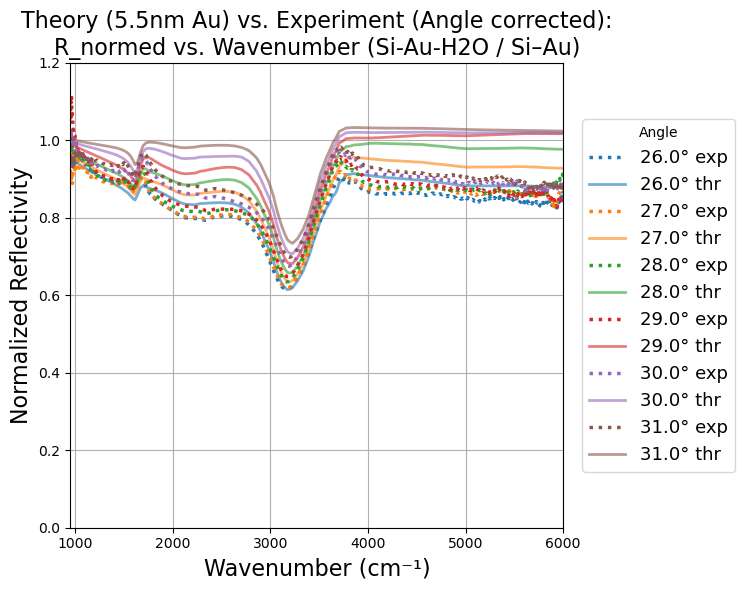

In [28]:
target_angles = np.array([26,27,28,29,30,31])
# target_angles = np.array([20,21,22,23,24,25])
# target_angles = [5,8,10,12,14,16,18,20]
# target_angles = [34,36,38,40,42,44,46,47]
# target_angles = [20,21,22,23,24,25,26,27,28,29]
# target_angles = [5, 8,10, 15, 19, 23, 25, 30, 40] 
# target_angles = np.array([20,23,25,28,32,36,40,44,47])



# Match to closest available angles in your dataset
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]
matched_angle_values = np.round(matched_angle_values, 1)

# Create colormap for consistent colors
num_angles = len(matched_angle_values)
# cmap = plt.get_cmap("nipy_spectral", num_angles) 
cmap = plt.get_cmap("tab10")


# --- Plot ---
plt.figure(figsize=(9.5, 6))

for i, (idx, angle) in enumerate(zip(matched_angle_indices, matched_angle_values)):
    color = cmap(i)  # Use modulo in case more than 10 angles

    # Experimental smoothed R
    df = data_normed_smoothed[angle]
    wavenumbers_exp = df["wavenumber"].values
    reflectance = df["Smoothed Normed R"].values
    plt.plot(wavenumbers_exp, reflectance, linewidth=2.5, linestyle=':',color=color,alpha=1, label=f"{angle:.1f}° exp")

    # Theoretical smoothed R
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]
    plt.plot(wavenumbers, Rnorm_curve,linewidth=2, label=f"{angle:.1f}° thr", color=color, alpha=0.6)
    

# --- Customize plot ---
plt.title(
    f"Theory ({d_gold * 1e9}nm Au) vs. Experiment (Angle corrected):\n"
    "R_normed vs. Wavenumber (Si-Au-H2O / Si–Au)",
    fontsize=16
)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)

# Legend outside the plot
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5),fontsize=13)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Make space for legend

plt.show()


--------------------------------------------

--------------------Rescaling calculations------------------------

In [29]:
print(exp_wavenumbers)
print(exp_Rnorm_47)
print(Rnorm_smooth_dict[47])

# ratio_array_1 = smooth_by_wavenumber(scale_dic[1])
# ratio_array_2 = smooth_by_wavenumber(scale_dic[2])
# ratio_array_3 = smooth_by_wavenumber(scale_dic[3])
# ratio_array_4 = smooth_by_wavenumber(scale_dic[4])
# ratio_array_5 = smooth_by_wavenumber(scale_dic[5])
# wavenumbers_toplot = scale_dic[1].iloc[:, 0].values

[ 399.26312622  401.19193359  403.12074097 ... 5996.6621228  5998.59093018
 6000.51973755]
[0.98320359 0.99431793 1.02641475 ... 1.05342997 1.05379563 1.04938821]
[1.0035931  1.00367214 1.00375526 ... 1.09150472 1.09144975 1.09139474]


In [30]:
# --- !! SCALING ARRAY!! ---
scaling_array = exp_Rnorm_47/Rnorm_smooth_dict[47]

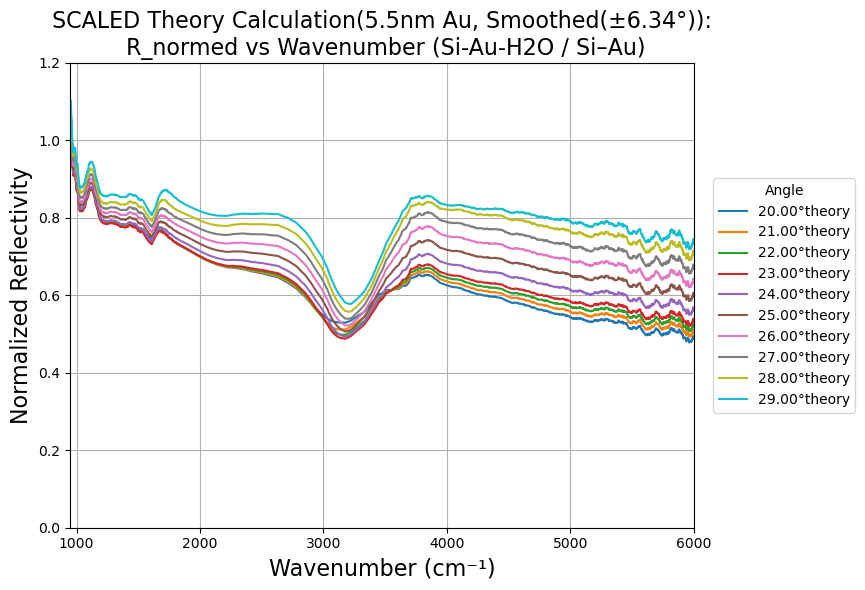

In [31]:
# R vs. wavenumber smoothed
# --- Select target angles (in degrees) ---
# target_angles = [15, 17, 18, 19, 20, 23, 30, 40, 50]     
target_angles = np.array([20,21,22,23,24,25,26,27,28,29])
# target_angles = [34,36,38,40,42,44,46,48,50]


matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]
matched_angle_values = np.round(matched_angle_values, 1)

# --- Plot ---
plt.figure(figsize=(11, 6))

for idx, angle in zip(matched_angle_indices, matched_angle_values):
    #Rnorm_curve = Rnorm_smooth[idx, :]
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]
    Rnorm_curve1 = Rnorm_scaled_array[idx, :]
    

    # plt.plot(wavenumbers, ratio_array_5*Rnorm_curve, label=f"{angle:.2f}°theory", alpha=1)
    plt.plot(wavenumbers, Rnorm_curve1, label=f"{angle:.2f}°theory", alpha=1)


# --- Customize plot ---
plt.title(f"SCALED Theory Calculation({d_gold*1e9}nm Au, Smoothed(±{window}°)):\n R_normed vs Wavenumber (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)
# Place legend outside
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend

plt.show()



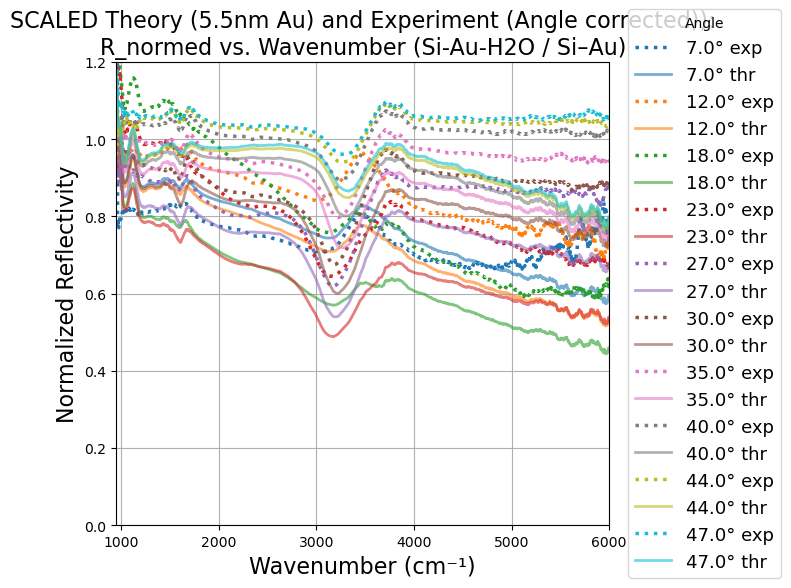

In [35]:
# --- Select target angles (in degrees) ---
# target_angles = [15, 17, 18, 19, 20, 23, 30, 40, 47]
# target_angles = [20,21,22,23,24]
# target_angles = [20,21,22,23,24,25,26,27,28,29]
# target_angles = [34,36,38,40,42,44,46,47]
# target_angles = [5,8,10,12,14,16,18,20]
# target_angles = np.array([20,23,25,28,32,36,40,44,47])

target_angles = np.array([7,12,18,23,27,30,35,40,44,47])

# Match to closest available angles in your dataset
matched_angle_indices = [np.argmin(np.abs(angles_all - a)) for a in target_angles]
matched_angle_values = [angles_all[i] for i in matched_angle_indices]
matched_angle_values = np.round(matched_angle_values, 1)

# Create colormap for consistent colors
num_angles = len(matched_angle_values)
# cmap = plt.get_cmap("nipy_spectral", num_angles) 
cmap = plt.get_cmap("tab10")


# --- Plot ---
plt.figure(figsize=(9.5, 6))

for i, (idx, angle) in enumerate(zip(matched_angle_indices, matched_angle_values)):
    color = cmap(i)  # Use modulo in case more than 10 angles

    # Experimental smoothed R
    df = data_normed_smoothed[angle]
    wavenumbers_exp = df["wavenumber"].values
    reflectance = df["Smoothed Normed R"].values
    plt.plot(wavenumbers_exp, reflectance, linewidth=2.5,  linestyle=':', color=color,alpha=1, label=f"{angle:.1f}° exp")

    # Theoretical smoothed R
    Rnorm_curve = Rnorm_smooth_ratio[idx, :]
    Rnorm_curve1 = Rnorm_scaled_array[idx, :]
    # plt.plot(wavenumbers, ratio_array_5 * Rnorm_curve,linewidth=2, label=f"{angle:.1f}° theory", color=color, alpha=0.6)

    plt.plot(wavenumbers, Rnorm_curve1,linewidth=2, label=f"{angle:.1f}° thr", color=color, alpha=0.6)
    

# --- Customize plot ---
plt.title(
    f"SCALED Theory ({d_gold * 1e9}nm Au) and Experiment (Angle corrected)):\n"
    "R_normed vs. Wavenumber (Si-Au-H2O / Si–Au)",
    fontsize=16
)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.xlim(950, 6000)
plt.ylim(0, 1.2)
plt.grid(True)

# Legend outside the plot
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5),fontsize=13)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Make space for legend

plt.show()


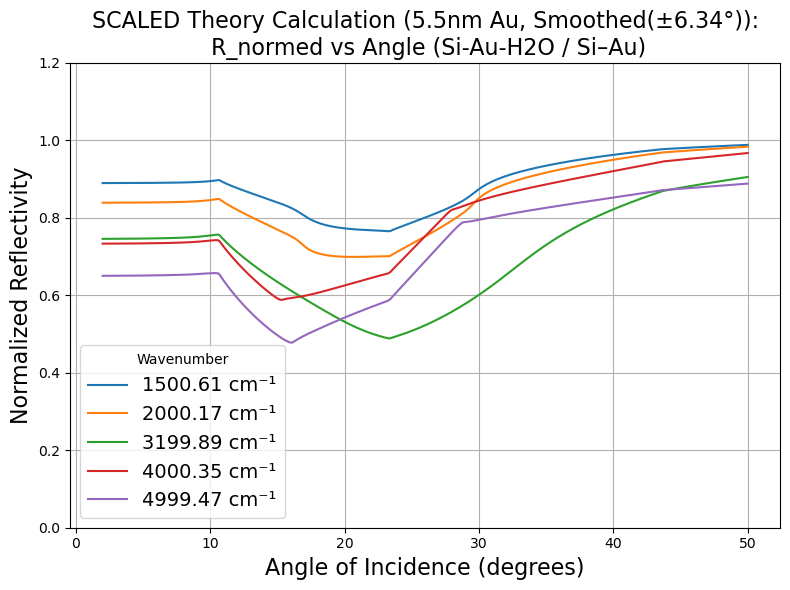

In [33]:
# --- Select target wavenumbers (approximate values) ---
selected_wavenumbers = [1500, 2000, 3200, 4000, 5000]

# Match target wavenumbers to nearest in clipped wavenumber array
matched_wn_indices = [
    np.argmin(np.abs(wavenumbers - wn)) for wn in selected_wavenumbers
]
matched_wn_values = [wavenumbers[i] for i in matched_wn_indices]

# --- Convert to NumPy array if not already ---
Rnorm_smooth = np.array(Rnorm_smooth)

# --- Prepare figure ---
plt.figure(figsize=(8, 6))

# --- Plot Rnorm vs angle for each selected wavenumber ---
for idx, wn in zip(matched_wn_indices, matched_wn_values):
    #Rnorm_curve = Rnorm_smooth[:, idx]
    Rnorm_curve = Rnorm_scaled_array[:, idx]
    plt.plot(angles_all, Rnorm_curve, label=f"{wn:.2f} cm⁻¹")

# --- Customize plot ---
plt.title(f"SCALED Theory Calculation ({d_gold*1e9}nm Au, Smoothed(±{window}°)):\n R_normed vs Angle (Si-Au-H2O / Si–Au)", fontsize=16)
plt.xlabel("Angle of Incidence (degrees)", fontsize=16)
plt.ylabel("Normalized Reflectivity", fontsize=16)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Wavenumber", fontsize=14)
plt.tight_layout()
plt.show()



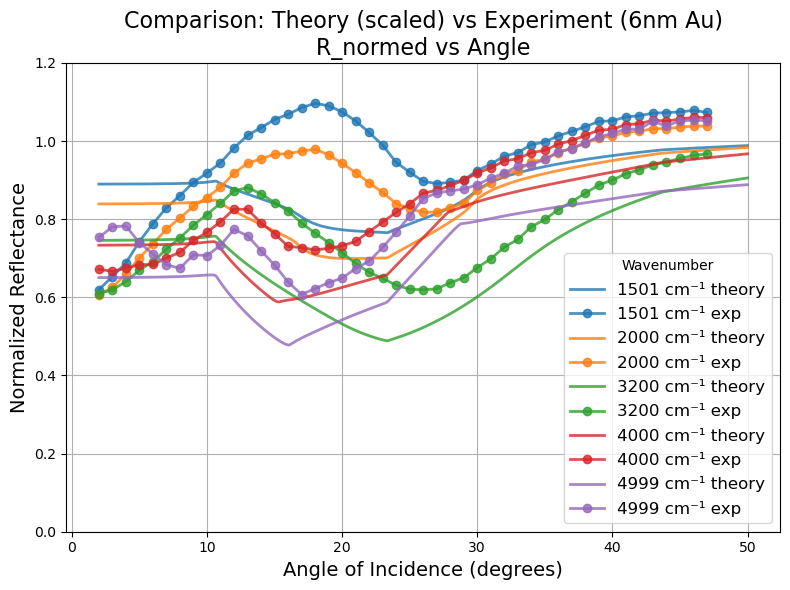

In [34]:
# --- Select target wavenumbers (cm⁻¹) ---
selected_wavenumbers = [1500, 2000, 3200, 4000, 5000]

# --- Match theory wavenumbers to indices ---
matched_wn_indices = [
    np.argmin(np.abs(wavenumbers - wn)) for wn in selected_wavenumbers
]
matched_wn_values = [wavenumbers[i] for i in matched_wn_indices]

# --- Match experimental wavenumbers to nearest available ---
sample_df = next(iter(data_normed_smoothed.values()))
available_wavenumbers = sample_df["wavenumber"].values
matched_wn_exp = [
    available_wavenumbers[np.argmin(np.abs(available_wavenumbers - wn))]
    for wn in selected_wavenumbers
]

# --- Sorted angle lists ---
angles_theory = angles_all
angles_exp = sorted(data_normed_smoothed.keys())

# --- Prepare colormap ---
cmap = plt.get_cmap("tab10")
colors = [cmap(i % cmap.N) for i in range(len(selected_wavenumbers))]

# --- Plot ---
plt.figure(figsize=(8, 6))

for i, (idx_theory, wn_theory, wn_exp) in enumerate(zip(matched_wn_indices, matched_wn_values, matched_wn_exp)):
    color = colors[i]

    # --- Theory curve ---
    R_theory = Rnorm_scaled_array[:, idx_theory]
    plt.plot(angles_theory, R_theory, linestyle='-', linewidth=2, color=color, label=f"{wn_theory:.0f} cm⁻¹ theory",alpha = 0.8)

    # --- Experimental curve ---
    R_exp = []
    for angle in angles_exp:
        df = data_normed_smoothed[angle]
        row = df[np.isclose(df["wavenumber"], wn_exp)]
        if not row.empty:
            R_exp.append(row["Smoothed Normed R"].values[0])
        else:
            R_exp.append(np.nan)

    plt.plot(angles_exp, R_exp, linestyle='-', marker='o', linewidth=2, color=color, label=f"{wn_exp:.0f} cm⁻¹ exp",alpha = 0.8)

# --- Customize plot ---
plt.title(
    f"Comparison: Theory (scaled) vs Experiment ({d_gold*1e9:.0f}nm Au)\nR_normed vs Angle",
    fontsize=16
)
plt.xlabel("Angle of Incidence (degrees)", fontsize=14)
plt.ylabel("Normalized Reflectance", fontsize=14)
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="Wavenumber", fontsize=12)
plt.tight_layout()
plt.show()
